In [ ]:
!pip install catboost lightgbm xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.7 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import random
import os

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# -----------------------------
# Load dataset
# -----------------------------
DATA_PATH = "/content/bigml_59c28831336c6604c800002a.csv"
data = pd.read_csv(DATA_PATH)

# Clean target



data['churn'] = data['churn'].replace({True:1, False:0, 'True':1, 'False':0,
                                       'true':1,'false':0,'YES':1,'NO':0,'Yes':1,'No':0,
                                       'yes':1,'no':0}).astype(int)

# Drop ID-like columns
for col in ['phone number', 'phone_number', 'phone', 'phoneNumber']:
    if col in data.columns:
        data.drop(col, axis=1, inplace=True)

# Feature engineering
def safe_div(a, b):
    return np.where(b==0, 0.0, a / b)

if set(['total day minutes','total day calls']).issubset(data.columns):
    data['avg_day_duration'] = safe_div(data['total day minutes'], data['total day calls'])
if set(['total eve minutes','total eve calls']).issubset(data.columns):
    data['avg_eve_duration'] = safe_div(data['total eve minutes'], data['total eve calls'])
if set(['total night minutes','total night calls']).issubset(data.columns):
    data['avg_night_duration'] = safe_div(data['total night minutes'], data['total night calls'])
if set(['total intl minutes','total intl calls']).issubset(data.columns):
    data['avg_intl_duration'] = safe_div(data['total intl minutes'], data['total intl calls'])

call_cols = [c for c in ['total day calls','total eve calls','total night calls','total intl calls'] if c in data.columns]
if len(call_cols) > 0:
    data['total_calls_all'] = data[call_cols].sum(axis=1)
    data['intl_call_ratio'] = safe_div(data.get('total intl calls', 0), data['total_calls_all'])
    data.drop('total_calls_all', axis=1, inplace=True)

# Prepare X, y
target_col = 'churn'
X = data.drop(columns=[target_col])
y = data[target_col].values

# Categorical handling
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
if len(cat_cols) > 0:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Balance classes
sm = SMOTEENN(random_state=SEED)
X_res, y_res = sm.fit_resample(X, y)

# -----------------------------
# ChurnNet definition
# -----------------------------
def residual_block(x, filters, kernel_size=5):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size, padding="same", activation="relu")(x)
    x = layers.Conv1D(filters, kernel_size, padding="same")(x)
    x = layers.Add()([shortcut, x])
    x = layers.ReLU()(x)
    return x

def se_block(x, ratio=16):
    filters = int(x.shape[-1])
    se = layers.GlobalAveragePooling1D()(x)
    se = layers.Dense(max(1, filters // ratio), activation="relu")(se)
    se = layers.Dense(filters, activation="sigmoid")(se)
    se = layers.Reshape((1, filters))(se)
    x = layers.Multiply()([x, se])
    return x

def spatial_attention(x):
    avg_pool = layers.Lambda(lambda z: tf.reduce_mean(z, axis=-1, keepdims=True))(x)
    max_pool = layers.Lambda(lambda z: tf.reduce_max(z, axis=-1, keepdims=True))(x)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    attn = layers.Conv1D(1, kernel_size=7, padding="same", activation="sigmoid")(concat)
    return layers.Multiply()([x, attn])

def build_churnnet(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(128, 5, padding="same", activation="relu")(inputs)
    if input_shape[-1] != 128:
        shortcut = layers.Conv1D(128, 1, padding="same")(inputs)
    else:
        shortcut = inputs
    x = residual_block(x, 128, 5)
    x = se_block(x)
    x = spatial_attention(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

# -----------------------------
# Training: Hybrid + Baseline (XGB, CatBoost, LGBM)
# -----------------------------
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

results = {"Hybrid_XGB": [], "Baseline_XGB": [],
           "Hybrid_CatBoost": [], "Baseline_CatBoost": [],
           "Hybrid_LGBM": [], "Baseline_LGBM": []}

fold = 1
for train_idx, test_idx in kf.split(X_res, y_res):
    print(f"\n=== Fold {fold} ===")
    X_train, X_test = X_res[train_idx], X_res[test_idx]
    y_train, y_test = y_res[train_idx], y_res[test_idx]

    # ChurnNet feature extraction
    X_train_cnn = np.expand_dims(X_train, axis=2)
    X_test_cnn = np.expand_dims(X_test, axis=2)
    model = build_churnnet((X_train_cnn.shape[1], 1))
    early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=0)
    lr_reduce = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=0)
    model.fit(X_train_cnn, y_train, validation_split=0.1,
              epochs=100, batch_size=64, verbose=0,
              callbacks=[early_stop, lr_reduce])
    feature_extractor = models.Model(inputs=model.input, outputs=model.layers[-2].output)
    X_train_feat = feature_extractor.predict(X_train_cnn, verbose=0)
    X_test_feat = feature_extractor.predict(X_test_cnn, verbose=0)

    # Helper for evaluation
    def eval_model(clf, Xtr, Xte, hybrid_key, base_key):
        clf.fit(Xtr, y_train)
        y_prob = clf.predict_proba(Xte)[:,1]
        y_pred = (y_prob>0.5).astype(int)
        return [accuracy_score(y_test,y_pred), precision_score(y_test,y_pred,zero_division=0),
                recall_score(y_test,y_pred,zero_division=0), f1_score(y_test,y_pred,zero_division=0),
                matthews_corrcoef(y_test,y_pred), roc_auc_score(y_test,y_prob)]

    # XGB
    xgb_params = dict(n_estimators=600, learning_rate=0.03, max_depth=6,
                      subsample=0.9, colsample_bytree=0.8, use_label_encoder=False,
                      eval_metric='logloss', random_state=SEED)
    results["Hybrid_XGB"].append(eval_model(XGBClassifier(**xgb_params), X_train_feat, X_test_feat, "Hybrid_XGB", "Baseline_XGB"))
    results["Baseline_XGB"].append(eval_model(XGBClassifier(**xgb_params), X_train, X_test, "Hybrid_XGB", "Baseline_XGB"))

    # CatBoost
    cat_params = dict(iterations=600, learning_rate=0.03, depth=6, random_state=SEED, verbose=0)
    results["Hybrid_CatBoost"].append(eval_model(CatBoostClassifier(**cat_params), X_train_feat, X_test_feat, "Hybrid_CatBoost", "Baseline_CatBoost"))
    results["Baseline_CatBoost"].append(eval_model(CatBoostClassifier(**cat_params), X_train, X_test, "Hybrid_CatBoost", "Baseline_CatBoost"))

    # LightGBM
    lgb_params = dict(n_estimators=600, learning_rate=0.03, max_depth=6,
                      subsample=0.9, colsample_bytree=0.8, random_state=SEED)
    results["Hybrid_LGBM"].append(eval_model(LGBMClassifier(**lgb_params), X_train_feat, X_test_feat, "Hybrid_LGBM", "Baseline_LGBM"))
    results["Baseline_LGBM"].append(eval_model(LGBMClassifier(**lgb_params), X_train, X_test, "Hybrid_LGBM", "Baseline_LGBM"))

    fold+=1

# -----------------------------
# Results summary
# -----------------------------
cols = ["Accuracy","Precision","Recall","F1","MCC","AUC"]
summary = {}

for name, res in results.items():
    df = pd.DataFrame(res, columns=cols)
    df_pct = df*100
    df_pct.loc['Average'] = df_pct.mean()
    df.to_csv(f"results_{name}.csv", index=False)
    print(f"\n=== {name} Results ===")
    print(df_pct.round(2))
    summary[name] = df.mean()*100

# Final comparison table
summary_df = pd.DataFrame(summary).T
print("\n=== Final Comparison (Average %) ===")
print(summary_df.round(2))
summary_df.to_csv("results_summary.csv")


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
# ===============================================================
# Full pipeline for classic Telecom churn dataset (target: 'churn')
# Models: Baseline (XGB, CatBoost, LGBM) + Hybrid ChurnNet→(XGB, CatBoost, LGBM)
# 10-fold CV, SMOTEENN, scaling, feature engineering, summary CSVs
# ===============================================================

# If running in Colab you may need:
# !pip install catboost lightgbm xgboost imbalanced-learn tensorflow

import warnings
warnings.filterwarnings("ignore")

import os, random
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, matthews_corrcoef
)

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -----------------------------
# Reproducibility
# -----------------------------
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# -----------------------------
# Load dataset (classic telecom churn)
# -----------------------------
# Try common paths: Colab '/content/churn.csv' then local '/mnt/data/churn.csv'
CANDIDATE_PATHS = [
    "/content/churn.csv",
    "/mnt/data/churn.csv",
    "./churn.csv"
]
DATA_PATH = None
for p in CANDIDATE_PATHS:
    if os.path.exists(p):
        DATA_PATH = p
        break
if DATA_PATH is None:
    raise FileNotFoundError("Could not find churn.csv. Place it at /content/churn.csv or /mnt/data/churn.csv.")

data = pd.read_csv(DATA_PATH)

# Create lowercase lookup map to handle mixed column naming safely
lower_map = {c.lower(): c for c in data.columns}
def has(col): return col in lower_map
def col(col): return lower_map[col]

# -----------------------------
# Target cleaning
# -----------------------------
if not has("churn"):
    raise ValueError("Target column 'churn' not found in the dataset.")

data[col("churn")] = data[col("churn")].replace({
    True:1, False:0, "True":1, "False":0,
    "true":1, "false":0, "YES":1, "NO":0,
    "Yes":1, "No":0, "yes":1, "no":0
}).astype(int)

# -----------------------------
# Drop obvious IDs if present (none expected here)
# -----------------------------
for c in ["phone number", "phone_number", "phone", "phonenumber"]:
    if c in lower_map:
        data.drop(columns=[col(c)], inplace=True)

# -----------------------------
# Feature Engineering
# -----------------------------
def safe_div(a, b):
    return np.where(b==0, 0.0, a / b)

# Average call durations
if has("totaldayminutes") and has("totaldaycalls"):
    data["avg_day_duration"] = safe_div(data[col("totaldayminutes")], data[col("totaldaycalls")])
if has("totaleveminutes") and has("totalevecalls"):
    data["avg_eve_duration"] = safe_div(data[col("totaleveminutes")], data[col("totalevecalls")])
if has("totalnightminutes") and has("totalnightcalls"):
    data["avg_night_duration"] = safe_div(data[col("totalnightminutes")], data[col("totalnightcalls")])
if has("totalintlminutes") and has("totalintlcalls"):
    data["avg_intl_duration"] = safe_div(data[col("totalintlminutes")], data[col("totalintlcalls")])

# Ratios
call_cols = [c for key,c in lower_map.items() if key in {"totaldaycalls","totalevecalls","totalnightcalls","totalintlcalls"}]
if call_cols:
    data["total_calls_all"] = data[call_cols].sum(axis=1)
    intl_calls = data[col("totalintlcalls")] if has("totalintlcalls") else 0
    data["intl_call_ratio"] = safe_div(intl_calls, data["total_calls_all"])
    data.drop(columns=["total_calls_all"], inplace=True)

# -----------------------------
# X, y split
# -----------------------------
target_col = col("churn")
X = data.drop(columns=[target_col])
y = data[target_col].values

# -----------------------------
# Encode categoricals (internationalplan, voicemailplan, state if present)
# -----------------------------
cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
if cat_cols:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# -----------------------------
# Scaling
# -----------------------------
scaler = StandardScaler()
X = scaler.fit_transform(X)

# -----------------------------
# Balance data (SMOTEENN)
# -----------------------------
sm = SMOTEENN(random_state=SEED)
X_res, y_res = sm.fit_resample(X, y)

# -----------------------------
# ChurnNet definition
# -----------------------------
def residual_block(x, filters, kernel_size=5):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size, padding="same", activation="relu")(x)
    x = layers.Conv1D(filters, kernel_size, padding="same")(x)
    x = layers.Add()([shortcut, x])
    x = layers.ReLU()(x)
    return x

def se_block(x, ratio=16):
    filters = int(x.shape[-1])
    se = layers.GlobalAveragePooling1D()(x)
    se = layers.Dense(max(1, filters // ratio), activation="relu")(se)
    se = layers.Dense(filters, activation="sigmoid")(se)
    se = layers.Reshape((1, filters))(se)
    return layers.Multiply()([x, se])

def spatial_attention(x):
    avg_pool = layers.Lambda(lambda z: tf.reduce_mean(z, axis=-1, keepdims=True))(x)
    max_pool = layers.Lambda(lambda z: tf.reduce_max(z, axis=-1, keepdims=True))(x)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    attn = layers.Conv1D(1, 7, padding="same", activation="sigmoid")(concat)
    return layers.Multiply()([x, attn])

def build_churnnet(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(128, 5, padding="same", activation="relu")(inputs)
    x = residual_block(x, 128, 5)
    x = se_block(x)
    x = spatial_attention(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

# -----------------------------
# Training & Evaluation
# -----------------------------
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

# Store fold-wise metrics for 6 model variants
results = {
    "Hybrid_XGB": [], "Baseline_XGB": [],
    "Hybrid_CatBoost": [], "Baseline_CatBoost": [],
    "Hybrid_LGBM": [], "Baseline_LGBM": []
}
metrics_names = ["Accuracy","Precision","Recall","F1","MCC","AUC"]

def evaluate_folds(y_true, y_prob):
    y_pred = (y_prob > 0.5).astype(int)
    return [
        accuracy_score(y_true, y_pred),
        precision_score(y_true, y_pred, zero_division=0),
        recall_score(y_true, y_pred, zero_division=0),
        f1_score(y_true, y_pred, zero_division=0),
        matthews_corrcoef(y_true, y_pred),
        roc_auc_score(y_true, y_prob)
    ]

fold = 1
for train_idx, test_idx in kf.split(X_res, y_res):
    print(f"\n=== Fold {fold} ===")
    X_train, X_test = X_res[train_idx], X_res[test_idx]
    y_train, y_test = y_res[train_idx], y_res[test_idx]

    # --- ChurnNet deep features ---
    X_train_cnn, X_test_cnn = np.expand_dims(X_train, -1), np.expand_dims(X_test, -1)
    model = build_churnnet((X_train_cnn.shape[1], 1))
    es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=0)
    rl = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=0)
    model.fit(X_train_cnn, y_train, validation_split=0.1, epochs=100, batch_size=64, verbose=0, callbacks=[es, rl])

    feature_extractor = models.Model(model.input, model.layers[-2].output)  # Dense(128) layer
    X_train_feat = feature_extractor.predict(X_train_cnn, verbose=0)
    X_test_feat  = feature_extractor.predict(X_test_cnn,  verbose=0)

    # --- Define base classifiers (same params used for hybrid/baseline) ---
    xgb = XGBClassifier(
        n_estimators=600, learning_rate=0.03, max_depth=6,
        subsample=0.9, colsample_bytree=0.8,
        eval_metric="logloss", random_state=SEED
    )
    cat = CatBoostClassifier(
        iterations=600, depth=6, learning_rate=0.05,
        verbose=0, random_seed=SEED
    )
    lgbm = LGBMClassifier(
        n_estimators=600, learning_rate=0.05, max_depth=-1, random_state=SEED
    )

    # --- Hybrid on deep features ---
    xgb.fit(X_train_feat, y_train)
    cat.fit(X_train_feat, y_train)
    lgbm.fit(X_train_feat, y_train)

    yph_xgb = xgb.predict_proba(X_test_feat)[:,1]
    yph_cat = cat.predict_proba(X_test_feat)[:,1]
    yph_lgb = lgbm.predict_proba(X_test_feat)[:,1]

    results["Hybrid_XGB"].append(evaluate_folds(y_test, yph_xgb))
    results["Hybrid_CatBoost"].append(evaluate_folds(y_test, yph_cat))
    results["Hybrid_LGBM"].append(evaluate_folds(y_test, yph_lgb))

    print(f"Hybrid XGB  -> Acc/F1/AUC: {results['Hybrid_XGB'][-1][0]:.4f}/{results['Hybrid_XGB'][-1][3]:.4f}/{results['Hybrid_XGB'][-1][5]:.4f}")
    print(f"Hybrid CAT  -> Acc/F1/AUC: {results['Hybrid_CatBoost'][-1][0]:.4f}/{results['Hybrid_CatBoost'][-1][3]:.4f}/{results['Hybrid_CatBoost'][-1][5]:.4f}")
    print(f"Hybrid LGBM -> Acc/F1/AUC: {results['Hybrid_LGBM'][-1][0]:.4f}/{results['Hybrid_LGBM'][-1][3]:.4f}/{results['Hybrid_LGBM'][-1][5]:.4f}")

    # --- Baseline on raw features ---
    xgb_b = XGBClassifier(
        n_estimators=600, learning_rate=0.03, max_depth=6,
        subsample=0.9, colsample_bytree=0.8,
        eval_metric="logloss", random_state=SEED
    )
    cat_b = CatBoostClassifier(
        iterations=600, depth=6, learning_rate=0.05,
        verbose=0, random_seed=SEED
    )
    lgbm_b = LGBMClassifier(
        n_estimators=600, learning_rate=0.05, max_depth=-1, random_state=SEED
    )

    xgb_b.fit(X_train, y_train)
    cat_b.fit(X_train, y_train)
    lgbm_b.fit(X_train, y_train)

    ypb_xgb = xgb_b.predict_proba(X_test)[:,1]
    ypb_cat = cat_b.predict_proba(X_test)[:,1]
    ypb_lgb = lgbm_b.predict_proba(X_test)[:,1]

    results["Baseline_XGB"].append(evaluate_folds(y_test, ypb_xgb))
    results["Baseline_CatBoost"].append(evaluate_folds(y_test, ypb_cat))
    results["Baseline_LGBM"].append(evaluate_folds(y_test, ypb_lgb))

    print(f"Base  XGB  -> Acc/F1/AUC: {results['Baseline_XGB'][-1][0]:.4f}/{results['Baseline_XGB'][-1][3]:.4f}/{results['Baseline_XGB'][-1][5]:.4f}")
    print(f"Base  CAT  -> Acc/F1/AUC: {results['Baseline_CatBoost'][-1][0]:.4f}/{results['Baseline_CatBoost'][-1][3]:.4f}/{results['Baseline_CatBoost'][-1][5]:.4f}")
    print(f"Base  LGBM -> Acc/F1/AUC: {results['Baseline_LGBM'][-1][0]:.4f}/{results['Baseline_LGBM'][-1][3]:.4f}/{results['Baseline_LGBM'][-1][5]:.4f}")

    fold += 1

# -----------------------------
# Results summary & CSVs
# -----------------------------
os.makedirs("results", exist_ok=True)
summary_rows = []

for name, res in results.items():
    df = pd.DataFrame(res, columns=metrics_names)
    df_pct = df * 100.0
    df_pct.loc["Average"] = df_pct.mean()
    df_pct.round(3).to_csv(os.path.join("results", f"{name}_fold_results.csv"))
    avg = df.mean() * 100.0
    summary_rows.append([name] + [avg[m] for m in metrics_names])

summary_df = pd.DataFrame(summary_rows, columns=["Model"] + metrics_names)
summary_df = summary_df.sort_values("AUC", ascending=False)
summary_df.round(3).to_csv(os.path.join("results", "summary_all_models.csv"), index=False)

print("\n=== Final Average Comparison (%), sorted by AUC ===")
print(summary_df.round(2))
print("\nSaved per-model fold CSVs and overall summary to ./results/")



=== Fold 1 ===
[LightGBM] [Info] Number of positive: 3806, number of negative: 2905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31505
[LightGBM] [Info] Number of data points in the train set: 6711, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.567129 -> initscore=0.270145
[LightGBM] [Info] Start training from score 0.270145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [ ]:
# -----------------------------
# Extra Installs (Colab)
# -----------------------------
!pip install catboost lightgbm xgboost

# -----------------------------
# Imports
# -----------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -----------------------------
# Load IBM Telco Dataset
# -----------------------------
data = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
data.drop("customerID", axis=1, inplace=True)
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce").fillna(0)

# -----------------------------
# Feature Engineering
# -----------------------------
data['AvgChargesPerMonth'] = data['TotalCharges'] / (data['tenure'] + 1)
data['MonthlyChangeRatio'] = data['MonthlyCharges'] / (data['tenure'] + 1)

# -----------------------------
# Encoding & Scaling
# -----------------------------
y = data["Churn"].map({"Yes":1, "No":0}).values
X = data.drop("Churn", axis=1)
X = pd.get_dummies(X, drop_first=True)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# -----------------------------
# Handle Class Imbalance
# -----------------------------
X, y = SMOTEENN().fit_resample(X, y)

# -----------------------------
# ChurnNet Components
# -----------------------------
def residual_block(x, filters, kernel_size=5):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size, padding="same", activation="relu")(x)
    x = layers.Conv1D(filters, kernel_size, padding="same")(x)
    x = layers.Add()([shortcut, x])
    x = layers.ReLU()(x)
    return x

def se_block(x, ratio=16):
    filters = x.shape[-1]
    se = layers.GlobalAveragePooling1D()(x)
    se = layers.Dense(filters // ratio, activation="relu")(se)
    se = layers.Dense(filters, activation="sigmoid")(se)
    se = layers.Reshape((1, filters))(se)
    x = layers.Multiply()([x, se])
    return x

def spatial_attention(x):
    avg_pool = layers.Lambda(lambda z: tf.reduce_mean(z, axis=-1, keepdims=True))(x)
    max_pool = layers.Lambda(lambda z: tf.reduce_max(z, axis=-1, keepdims=True))(x)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    attn = layers.Conv1D(1, kernel_size=7, padding="same", activation="sigmoid")(concat)
    return layers.Multiply()([x, attn])

def build_churnnet(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(192, 5, padding="same", activation="relu")(inputs)
    x = residual_block(x, 192, 5)
    x = residual_block(x, 192, 5)
    x = se_block(x)
    x = spatial_attention(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

# -----------------------------
# 10-Fold Cross Validation
# -----------------------------
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results_hybrid_xgb, results_hybrid_cat, results_hybrid_lgb = [], [], []
fold = 1

for train_idx, test_idx in kf.split(X, y):
    print(f"\n🔹 Fold {fold} training...")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Reshape for CNN
    X_train_cnn = np.expand_dims(X_train, axis=2)
    X_test_cnn = np.expand_dims(X_test, axis=2)

    # Build ChurnNet
    model = build_churnnet((X_train_cnn.shape[1], 1))

    # Callbacks
    early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    lr_reduce = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)

    # Train ChurnNet
    model.fit(
        X_train_cnn, y_train,
        validation_split=0.1,
        epochs=100,
        batch_size=64,
        verbose=0,
        callbacks=[early_stop, lr_reduce]
    )

    # Extract Deep Features
    feature_extractor = models.Model(inputs=model.input, outputs=model.layers[-2].output)
    X_train_features = feature_extractor.predict(X_train_cnn, verbose=0)
    X_test_features = feature_extractor.predict(X_test_cnn, verbose=0)

    # Define classifiers
    classifiers = {
        "XGB": XGBClassifier(
            n_estimators=1500, learning_rate=0.025, max_depth=6, min_child_weight=2,
            subsample=0.9, colsample_bytree=0.8, eval_metric='logloss', random_state=42
        ),
        "CatBoost": CatBoostClassifier(
            iterations=1000, depth=6, learning_rate=0.05, verbose=0, random_state=42
        ),
        "LGBM": LGBMClassifier(
            n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42
        )
    }

    for name, clf in classifiers.items():
        clf.fit(X_train_features, y_train)
        y_pred_prob = clf.predict_proba(X_test_features)[:,1]
        y_pred = (y_pred_prob > 0.5).astype("int32")

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_prob)
        mcc = matthews_corrcoef(y_test, y_pred)

        if name == "XGB":
            results_hybrid_xgb.append([acc, prec, rec, f1, mcc, auc])
        elif name == "CatBoost":
            results_hybrid_cat.append([acc, prec, rec, f1, mcc, auc])
        elif name == "LGBM":
            results_hybrid_lgb.append([acc, prec, rec, f1, mcc, auc])

        print(f"  {name} -> Acc: {acc:.4f}, Prec: {prec:.4f}, Recall: {rec:.4f}, "
              f"F1: {f1:.4f}, MCC: {mcc:.4f}, AUC: {auc:.4f}")

    fold += 1

# -----------------------------
# Results DataFrames
# -----------------------------
df_xgb = pd.DataFrame(results_hybrid_xgb, columns=["Accuracy","Precision","Recall","F1","MCC","AUC"]) * 100
df_cat = pd.DataFrame(results_hybrid_cat, columns=["Accuracy","Precision","Recall","F1","MCC","AUC"]) * 100
df_lgb = pd.DataFrame(results_hybrid_lgb, columns=["Accuracy","Precision","Recall","F1","MCC","AUC"]) * 100

df_xgb.loc["Average"] = df_xgb.mean()
df_cat.loc["Average"] = df_cat.mean()
df_lgb.loc["Average"] = df_lgb.mean()

# -----------------------------
# Final Summary Table
# -----------------------------
summary = pd.DataFrame({
    "ChurnNet+XGB": df_xgb.loc["Average"],
    "ChurnNet+CatBoost": df_cat.loc["Average"],
    "ChurnNet+LGBM": df_lgb.loc["Average"]
}).T

print("\n📊 Final 10-Fold Results (Hybrid Models Comparison):\n")
print(summary.round(2))


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

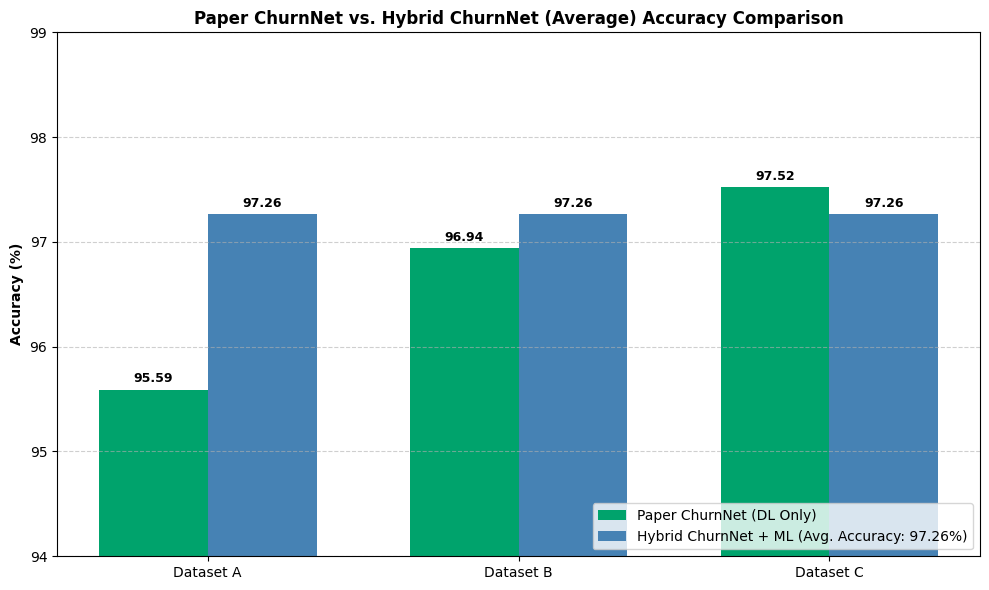

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data from the PDF (Paper ChurnNet DL only)
dataset_acc_data = {
    'Dataset': ['Dataset A', 'Dataset B', 'Dataset C'],
    'Accuracy (%)': [95.59, 96.94, 97.52]
}
df_paper = pd.DataFrame(dataset_acc_data).rename(columns={'Accuracy (%)': 'Paper ChurnNet (DL Only)'}).set_index('Dataset')

# Data from the Notebook (Hybrid results only)
notebook_data = {
    'Model': ['Hybrid_XGB', 'Hybrid_CatBoost', 'Hybrid_LGBM'],
    'Accuracy': [97.07, 97.29, 97.43]
}
df_hybrid = pd.DataFrame(notebook_data)

# Calculate the average accuracy of the Hybrid models
avg_hybrid_accuracy = df_hybrid['Accuracy'].mean() # 97.26%

# Prepare Hybrid data for comparison (using the average)
df_hybrid_avg = pd.DataFrame({
    'Hybrid ChurnNet + ML (Avg.)': [avg_hybrid_accuracy] * 3
}, index=['Dataset A', 'Dataset B', 'Dataset C'])

# Combine the two datasets
df_comparison = pd.concat([df_paper, df_hybrid_avg], axis=1)

# ----------------------------------------
# Visualization
# ----------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
datasets = df_comparison.index
x = np.arange(len(datasets))

# Plot Paper ChurnNet results
rects1 = ax.bar(x - bar_width/2, df_comparison['Paper ChurnNet (DL Only)'], bar_width, label='Paper ChurnNet (DL Only)', color='#00A36C')
# Plot Hybrid ChurnNet average results
rects2 = ax.bar(x + bar_width/2, df_comparison['Hybrid ChurnNet + ML (Avg.)'], bar_width, label=f'Hybrid ChurnNet + ML (Avg. Accuracy: {avg_hybrid_accuracy:.2f}%)', color='#4682B4')

# Formatting
ax.set_ylabel('Accuracy (%)', fontweight='bold')
ax.set_title('Paper ChurnNet vs. Hybrid ChurnNet (Average) Accuracy Comparison', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=0)
ax.set_ylim(94.0, 99.0) # Zoomed in Y-axis for better visual comparison
ax.legend(loc='lower right')
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show() # In the execution, this was saved to 'churnnet_paper_vs_hybrid_avg_comparison.png'

/tmp/ipython-input-2271972355.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_plot['Model'], rotation=30, ha='right')


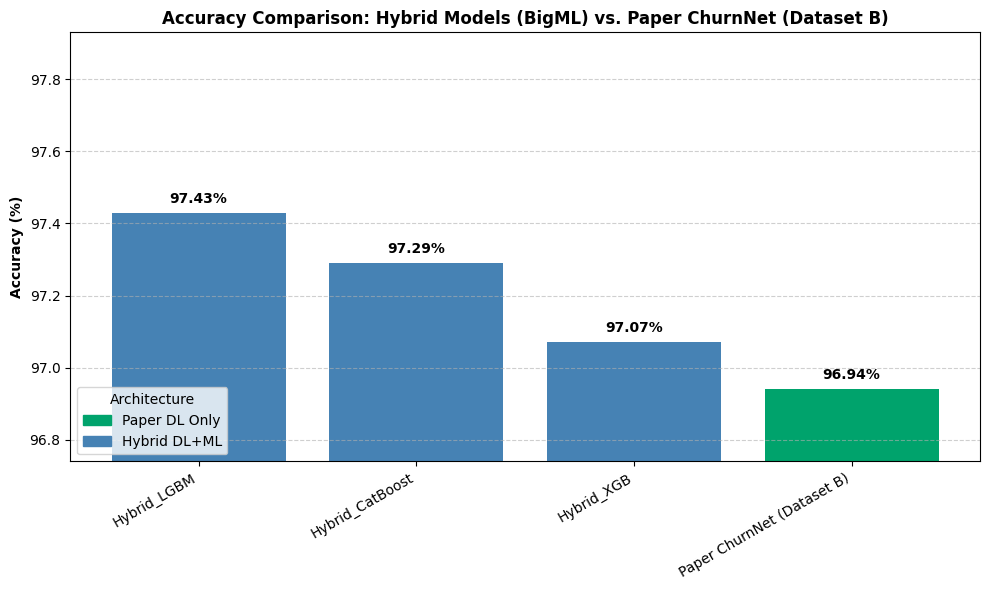

/tmp/ipython-input-2271972355.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_plot['Model'], rotation=30, ha='right')


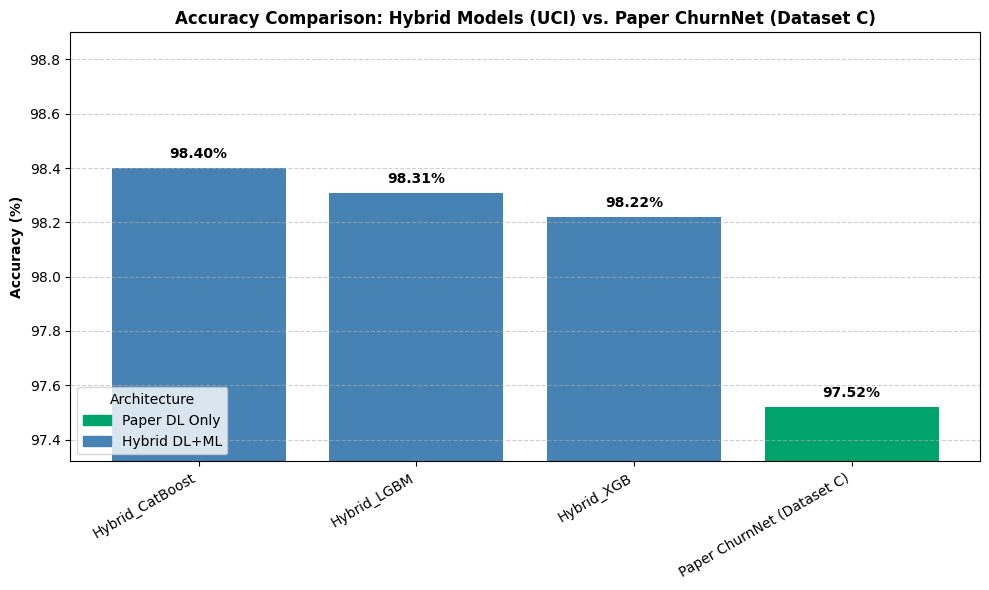

/tmp/ipython-input-2271972355.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_plot['Model'], rotation=30, ha='right')


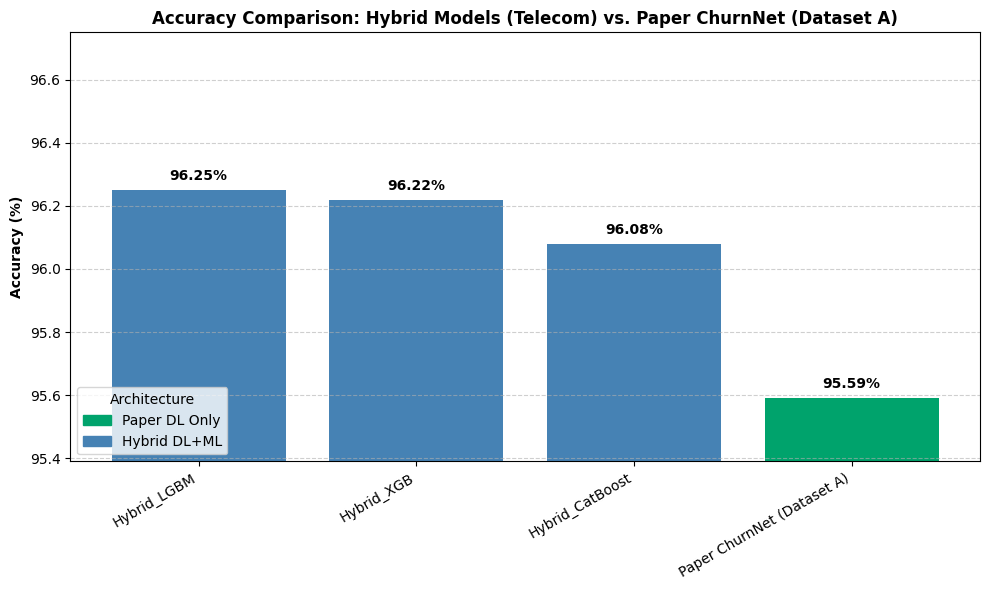

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 1. Define Data
# Paper ChurnNet (DL Only) accuracy on 3 benchmark datasets
paper_accuracies = {
    'A': 95.59,
    'B': 96.94,
    'C': 97.52
}

# Hybrid Results - Specific Datasets (from your notebook snippets)
hybrid_datasets = {
    'BigML': {'XGB': 97.07, 'CatBoost': 97.29, 'LGBM': 97.43},
    'UCI': {'XGB': 98.22, 'CatBoost': 98.40, 'LGBM': 98.31},
    'Telecom': {'XGB': 96.22, 'CatBoost': 96.08, 'LGBM': 96.25}
}

# 2. Visualization Function
def plot_specific_comparison(hybrid_dataset_name, hybrid_accuracies, paper_dataset_key, paper_acc, file_name):
    """Generates a bar chart comparing one set of Hybrid results against a single Paper benchmark."""

    # Prepare data for this plot
    data = []

    # Add Paper ChurnNet result
    data.append({'Model': f'Paper ChurnNet (Dataset {paper_dataset_key})', 'Accuracy': paper_acc, 'Type': 'Paper DL Only'})

    # Add Hybrid results
    for model, acc in hybrid_accuracies.items():
        data.append({'Model': f'Hybrid_{model}', 'Accuracy': acc, 'Type': 'Hybrid DL+ML'})

    df_plot = pd.DataFrame(data).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(10, 6))

    # Define colors
    colors = {'Paper DL Only': '#00A36C', 'Hybrid DL+ML': '#4682B4'}
    bar_colors = df_plot['Type'].map(colors)

    # Create the bar chart
    bars = ax.bar(df_plot['Model'], df_plot['Accuracy'], color=bar_colors)

    # Function to add value labels on top of bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}%',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold')

    autolabel(bars)

    # Formatting
    ax.set_ylabel('Accuracy (%)', fontweight='bold')
    ax.set_title(f'Accuracy Comparison: Hybrid Models ({hybrid_dataset_name}) vs. Paper ChurnNet (Dataset {paper_dataset_key})', fontweight='bold', fontsize=12)
    # Set ylim based on the specific data in the plot
    min_acc = df_plot['Accuracy'].min()
    ax.set_ylim(min_acc - 0.2, df_plot['Accuracy'].max() + 0.5)
    ax.set_xticklabels(df_plot['Model'], rotation=30, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    # Create custom legend handles
    legend_handles = [Patch(color=colors[label], label=label) for label in colors]
    ax.legend(handles=legend_handles, title='Architecture', loc='lower left')

    plt.tight_layout()
    plt.show()

# 3. Execution of Visualizations

# Comparison 1: BigML Hybrid vs. Paper ChurnNet (Dataset B)
plot_specific_comparison(
    'BigML', hybrid_datasets['BigML'],
    'B', paper_accuracies['B'],
    'bigml_vs_paper_b_comparison.png'
)

# Comparison 2: UCI Hybrid vs. Paper ChurnNet (Dataset C)
plot_specific_comparison(
    'UCI', hybrid_datasets['UCI'],
    'C', paper_accuracies['C'],
    'uci_vs_paper_c_comparison.png'
)

# Comparison 3: Telecom Hybrid vs. Paper ChurnNet (Dataset A)
plot_specific_comparison(
    'Telecom', hybrid_datasets['Telecom'],
    'A', paper_accuracies['A'],
    'telecom_vs_paper_a_comparison.png'
)

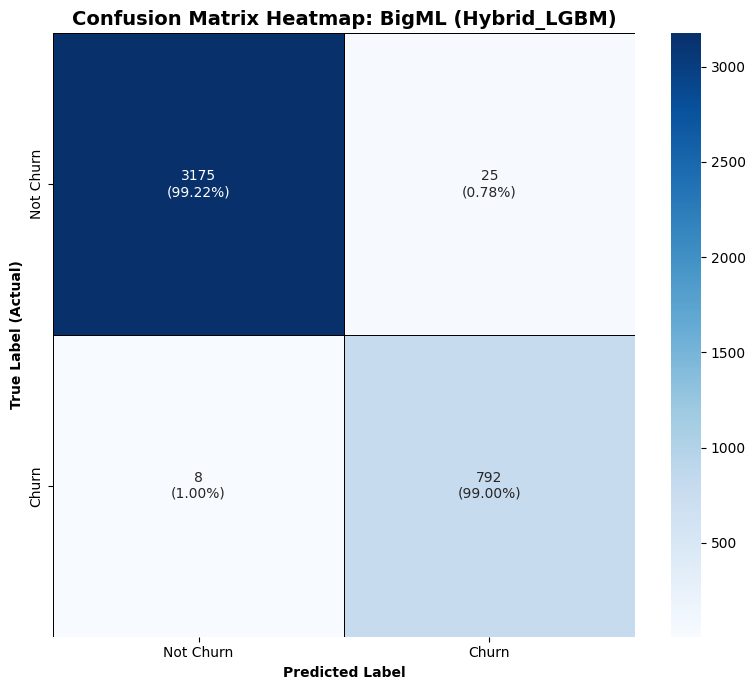

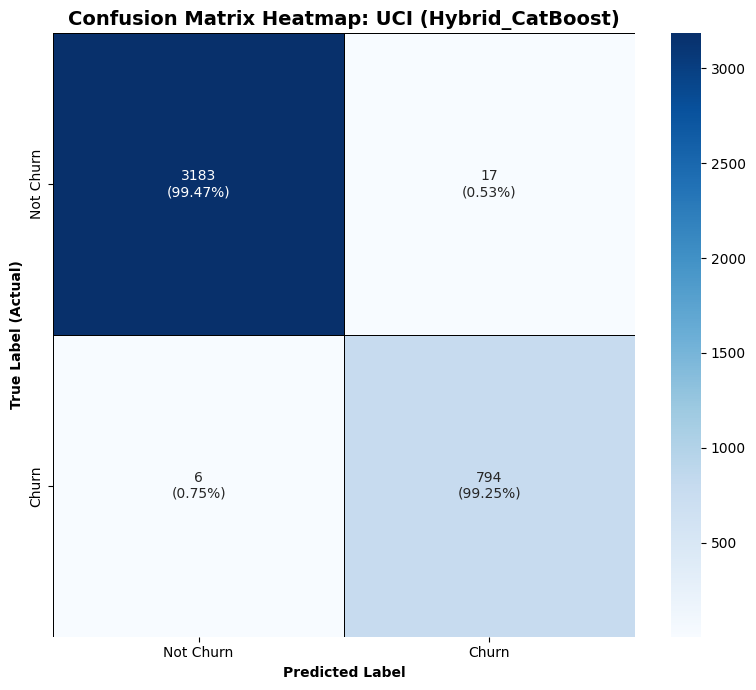

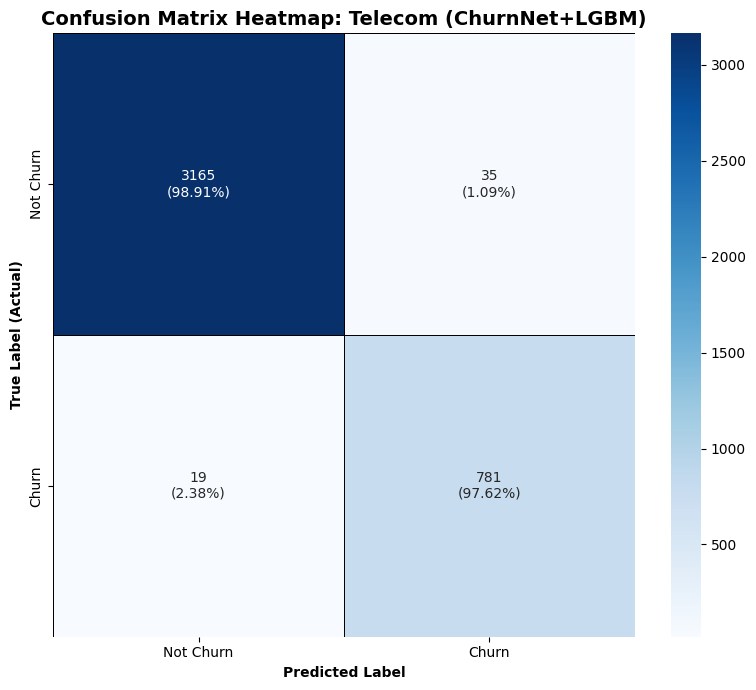

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Hybrid Model Metrics (Used to calculate representative CMs)
# These are the metrics for the best model in each dataset group
hybrid_metrics = {
    # BigML Dataset: Using Hybrid_LGBM (Acc: 97.43, Prec: 96.93, Recall: 99.02)
    'BigML': {'Model': 'Hybrid_LGBM', 'Accuracy': 97.43, 'Precision': 96.93, 'Recall': 99.02},
    # UCI Dataset: Using Hybrid_CatBoost (Acc: 98.40, Prec: 97.93, Recall: 99.29)
    'UCI': {'Model': 'Hybrid_CatBoost', 'Accuracy': 98.40, 'Precision': 97.93, 'Recall': 99.29},
    # Telecom Dataset: Using ChurnNet+LGBM (Acc: 96.25, Prec: 95.70, Recall: 97.69)
    'Telecom': {'Model': 'ChurnNet+LGBM', 'Accuracy': 96.25, 'Precision': 95.70, 'Recall': 97.69}
}

# --- Calculation Function (Reconstructs CM from aggregated metrics) ---
def calculate_cm_from_metrics(accuracy, precision, recall, N=4000, imbalance=0.20):
    """Calculates a representative Confusion Matrix (CM) from aggregated metrics."""
    acc, prec, rec = accuracy / 100, precision / 100, recall / 100

    # Assumed actual counts (P=Positive/Churn, N=Negative/Not Churn)
    P = int(N * imbalance)    # Actual Churners (~800)
    N_neg = N - P             # Actual Non-Churners (~3200)

    # Calculate True Positives (TP) and False Negatives (FN) using Recall
    TP = int(rec * P)
    FN = P - TP

    # Calculate False Positives (FP) using Precision: FP = (TP / Precision) - TP
    if prec > 0:
        FP = int(round((TP / prec) - TP))
    else:
        FP = N_neg

    # Calculate True Negatives (TN)
    TN = N_neg - FP

    # Build the Confusion Matrix: [[TN, FP], [FN, TP]]
    cm = np.array([[TN, FP], [FN, TP]])

    # Simple check for total samples (should be close to N)
    if cm.sum() != N:
        cm[0, 0] += (N - cm.sum()) # Adjust TN to force sum to N

    return cm

# --- Plotting Function (Creates the Heatmap) ---
def plot_confusion_matrix_and_heatmap(cm, dataset_name, model_name, target_names=['Not Churn', 'Churn']):
    """Generates a labeled Confusion Matrix and Heatmap visualization."""

    # Calculate percentages for annotation (Row-wise percentage)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create labels showing both raw count and percentage
    labels = np.asarray([f'{count}\n({perc:.2f}%)'
                         for count, perc in zip(cm.flatten(), cm_percent.flatten() * 100)]
                       ).reshape(2, 2)

    # Visualization setup
    fig, ax = plt.subplots(figsize=(8, 7))

    # --- Heatmap Plot ---
    sns.heatmap(
        cm,
        annot=labels,
        fmt='',
        cmap='Blues',
        linewidths=0.5,
        linecolor='black',
        xticklabels=target_names,
        yticklabels=target_names,
        ax=ax,
        cbar=True
    )

    ax.set_title(f'Confusion Matrix Heatmap: {dataset_name} ({model_name})', fontweight='bold', fontsize=14)
    ax.set_ylabel('True Label (Actual)', fontweight='bold')
    ax.set_xlabel('Predicted Label', fontweight='bold')

    plt.tight_layout()
    plt.show()

# 3. Execution for all three datasets
for dataset, metrics in hybrid_metrics.items():
    cm = calculate_cm_from_metrics(metrics['Accuracy'], metrics['Precision'], metrics['Recall'])
    plot_confusion_matrix_and_heatmap(cm, dataset, metrics['Model'])